# 提案手法の実験（ラベルが適切か出力）

## 26x26のウエハに限定して機械学習させる
- データオーギュメンテーション（鏡映，回転を追加）

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import csv

import numpy as np
import pandas as pd
import pickle
import copy
import cv2

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
import keras.backend.tensorflow_backend as tfback
# from tf.keras.utils import multi_gpu_model


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')

print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

MAKE_DATASET = False

Using TensorFlow backend.


['LSWMD.pkl']


### データについて

- データセットは811,457枚のウエハマップから構成されている．

- ウエハマップのそれぞれの列から得られる情報はないが，インスタンスごとにダイサイズが異なることがわかる．
- ウエハマップのダイサイズをチェックするための変数`WaferMapDim`を定義する．（縦，横の値）

In [3]:
if MAKE_DATASET:
    df=pd.read_pickle("../input/LSWMD.pkl")

    df = df.drop(['waferIndex'], axis = 1)

    def find_dim(x):
        dim0=np.size(x,axis=0)
        dim1=np.size(x,axis=1)
        return dim0,dim1
    df['waferMapDim']=df.waferMap.apply(find_dim)

- 不良パターンと学習orテストラベルを数値で表す．

In [4]:
if MAKE_DATASET:
    df['failureNum']=df.failureType
    df['trainTestNum']=df.trianTestLabel
    mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
    mapping_traintest={'Training':0,'Test':1}
    df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

    tol_wafers = df.shape[0]

    df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
    df_withlabel =df_withlabel.reset_index()
    df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
    df_withpattern = df_withpattern.reset_index()
    df_nonpattern = df[(df['failureNum']==8)]

### 26x26のデータに対して処理

In [5]:
if MAKE_DATASET:
    sub_df = df.loc[df['waferMapDim'] == (26, 26)]
    sub_wafer = sub_df['waferMap'].values

    sw = np.ones((1, 26, 26))
    label = list()

    for i in range(len(sub_df)):
        # skip null label
        if len(sub_df.iloc[i,:]['failureType']) == 0:
            continue
        sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
        label.append(sub_df.iloc[i,:]['failureType'][0][0])

    x = sw[1:]
    y = np.array(label).reshape((-1,1))

### xとyをファイルに保存

In [6]:
def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

if MAKE_DATASET:
    pickle_dump(x, './data/x2626.pickle')
    pickle_dump(y, './data/y2626.pickle')
    
if not MAKE_DATASET:
    x = pickle_load('./data/x2626.pickle')
    y = pickle_load('./data/y2626.pickle')

In [7]:
mask_x = np.zeros((24, 24))
dummy_x = cv2.resize(x[0], (24,24))
mask_x[dummy_x == 1] = 1 
mask_x[dummy_x == 2] = 1 
mask_x = mask_x.reshape((1, 24,24))

In [8]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


- 26x26のウエハが14366枚抽出できた．

In [9]:
# print(y[50][0])
# c = 0
# for i in range(len(y)):
#     if y[i][0] == 'Edge-Ring':
#         plt.imshow(x[i])
#         print(y[i])
#         plt.show()
#         c += 1
        
# print(c)

- 最初のデータを可視化してみる．
- その前に，26x26のデータでおかしなものを表示

In [10]:
for i in range(len(x)):
    error = np.where((x[0] != x[i]) & ((x[0] == 0) | (x[i] == 0)))

- おかしなウエハは除去する

In [11]:
error_list = []
for i in range(len(x)):
    error = np.where((x[0] != x[i]) & ((x[0] == 0) | (x[i] == 0)))
    if len(error[0]) > 0:
        error_list.append(i)
x = np.delete(x, error_list, 0)
y = np.delete(y, error_list, 0)
print(x.shape)
print(y.shape)

(14350, 26, 26)
(14350, 1)


- 形が異なるウエハを削除したところ，14350枚となった．

### かぶりの除去

In [12]:
# かぶっているものを特定する
# count = 0
# no = 0
# duplicate_list = []
# for i in range(x.shape[0]):
#     dup = 0
#     for j in range(i+1, x.shape[0]):
#         if np.array_equal(x[i], x[j]):
#             count += 1
#             dup += 1
#             if y[i][0] != y[j][0]:  
#                 no += 1
#                 print(str(i) + ":" + y[i][0] + ", " + str(j) + ":" + y[j][0])
#                 plt.imshow(x[i])
#                 plt.show()
#             else:
#                 duplicate_list.append(j)
#     if dup > 1:
#         print(i)

# print(count)
# print(no)
# print(duplicate_list)

- 重複しているウエハ（同じラベル）
    - `duplicate_list`
- 異なるラベル付けがされた重複しているウエハに対し，残すものをピックアップ
    - 565:none
    - 6944:Edge-Loc
    - 10875:Edge-Loc
    - 2103:Center
    - 9884:Loc
    - 10987:Edge-Loc
    - 11437:Edge-Loc
    - 4628:none
    - 5021:Edge-Loc
    - 9706:Loc
    - 9007:Loc
    - 10943:Edge-Loc
    - 9137:Edge-Loc
    - 11345:Edge-Loc
- 残さないものはdupulicate_listに追加
    - [8106, 1276, 1929, 10626, 2603, 3264, 3712, 11012, 9412, 5160, 5521, 5828, 6058, 6238]

In [13]:
duplicate_list = [7219, 8235, 6936, 7036, 6875, 8363, 7255, 7241, 7107, 7982, 7206, 7390, 7740, 7101, 7146, 7646, 7016, 10967, 6738, 9402, 6948, 6546, 8048, 7044, 7357, 8206, 7781, 6806, 6671, 6751, 6975, 10358, 7600, 11037, 6920, 7229, 11230, 6899, 6721, 7663, 7023, 6775, 7532, 9748, 10288, 7003, 8154, 8273, 7346, 7511, 7699, 7197, 10636, 10646, 6988, 8326, 8353, 7548, 7502, 10873, 8723, 10172, 8148, 7460, 7652, 7810, 7823, 7074, 6764, 6857, 8871, 7143, 7014, 9266, 7574, 7113, 8085, 7758, 7960, 7412, 10891, 8224, 8327, 6982, 8215, 7399, 7349, 7100, 8214, 6709, 8061, 6924, 8218, 7730, 8491, 6782, 6714, 7227, 8413, 7932, 9033, 6959, 9273, 6972, 7253, 7737, 10307, 8960, 7658, 9841, 9192, 7165, 8109, 6901, 7271, 8895, 7679, 7094, 6868, 7409, 8005, 7906, 8387, 7155, 8320, 7613, 8385, 8390, 10278, 7154, 7209, 7126, 7112, 9107, 9147, 7404, 7741, 6927, 7709, 6989, 6780, 8361, 7964, 8697, 8044, 7106, 7642, 10345, 8391, 7191, 7948, 8276, 7395, 6925, 9317, 7096, 8408, 7245, 10691, 8432, 7091, 7235, 8038, 7530, 10806, 7228, 10881, 10054, 6705, 10298, 7817, 7896, 6951, 8842, 7476, 7116, 7992, 6955, 6874, 8152, 6761, 6777, 8020, 7350, 6797, 9867, 7318, 11119, 7254, 10248, 6953, 7079, 7233, 8901, 9633, 8269, 6973, 8029, 7413, 8321, 7087, 8562, 7457, 7675, 7049, 10682, 7081, 8369, 6742, 9436, 6999, 7731, 7135, 8638, 7916, 10259, 6603, 6754, 6734, 6931, 7621, 8157, 6922, 7140, 7720, 6547, 7708, 6902, 7187, 8823, 11073, 8019, 7147, 7057, 8244, 9893, 6702, 7455, 8356, 8359, 8207, 7068, 10336, 6817, 7221, 7533, 8672, 8150, 7355, 6957, 7568, 7035, 9863, 7450, 6724, 6984, 6947, 6997, 7572, 10101, 6819, 8147, 6802, 6870, 7200, 8059, 7122, 7064, 7870, 8774, 7934, 7797, 8439, 7054, 6731, 7751, 9988, 9553, 8156, 6898, 9805, 10832, 7286, 10786, 7202, 6871, 8402, 7244, 6962, 8058, 10461, 7951, 7836, 7007, 6888, 7962, 6846, 9315, 7808, 8117, 8054, 6987, 6858, 7487, 7323, 7290, 7289, 7067, 10158, 7419, 9622, 8500, 9453, 10611, 7875, 8227, 8825, 6889, 7148, 8667, 6842, 7957, 10046, 7017, 7129, 10392, 6961, 8877, 9298, 7052, 10772, 7118, 7105, 10484, 7807, 10485, 6981, 7676, 7130, 7347, 8380, 7733, 6934, 6862, 6824, 8338, 9801, 6425, 7669, 8231, 6904, 7225, 9359, 7292, 8780, 7494, 8766, 7072, 7145, 10737, 7570, 6566, 10041, 7098, 10563, 8179, 8922, 7604, 7501, 6400, 7099, 7735, 10579, 9575, 7048, 6998, 6779, 6915, 9582, 8466, 7638, 7134, 9148, 6937, 9900, 10157, 7018, 7158, 7223, 6911, 8355, 10385, 10558, 10418, 10770, 6906, 7188, 9886, 7559, 6733, 9578, 6840, 10382, 9397, 8172, 9046, 9981, 10117, 7789, 7391, 7719, 6949, 6971, 8099, 7536, 8809, 8135, 7495, 8694, 7121, 7786, 7194, 10129, 7004, 8924, 10577, 6958, 9305, 7277, 6891, 7889, 7178, 6749, 8336, 7821, 10234, 7790, 9879, 8393, 7782, 9434, 7240, 10521, 6768, 7794, 7056, 7909, 7028, 9624, 6966, 7120, 8151, 10286, 7343, 8546, 8073, 7231, 6808, 7952, 8114, 7265, 7602, 7102, 9445, 7109, 8076, 10565, 8312, 6752, 9458, 10119, 6446, 9852, 6912, 6974, 7177, 6967, 7239, 8323, 9526, 8813, 7046, 7144, 7640, 8039, 8551, 7215, 6423, 8506, 6956, 6838, 7469, 8374, 7063, 10507, 9666, 6770, 7123, 7433, 8418, 8134, 9888, 6728, 8233, 7528, 7852, 8242, 10719, 7697, 7172, 6710, 10753, 11274, 7125, 10734, 8062, 6455, 8226, 6986, 10589, 6978, 6820, 7401, 7185, 7963, 6942, 7133, 10616, 6867, 9968, 7217, 7032, 8882, 9995, 8337, 7436, 9745, 6881, 10775, 7204, 6918, 7632, 7678, 6524, 7031, 6574, 10495, 8742, 6913, 7787, 7220, 10423, 9348, 9158, 7461, 7246, 10618, 6763, 7518, 10488, 8131, 7842, 9665, 10701, 6921, 6941, 7510, 10843, 10460, 7041, 8278, 7089, 7027, 7575, 7629, 7626, 7334, 10252, 7527, 6894, 6954, 8325, 10625, 10420, 9232, 7365, 8201, 10778, 6729, 6896, 6786, 7162, 7186, 9527, 9263, 7218, 7943, 6940, 7619, 6996, 6836, 7925, 10798, 7824, 10401, 8373, 8016, 8001, 7039, 10439, 8791, 9685, 7463, 7995, 8328, 7095, 10058, 7339, 7075, 6853, 8053, 6781, 8576, 7082, 8136, 10282, 8056, 6759, 8093, 7009, 6897, 7900, 10375, 7757, 10189, 8222, 8916, 8972, 6708, 10142, 6892, 7212, 7214, 7205, 6935, 8407, 7257, 7156, 8032, 7195, 6928, 7169, 6859, 8383, 7085, 6969, 7329, 9650, 7398, 6943, 6879, 7020, 8847, 10176, 8238, 10562, 7554, 8397, 7008, 7767, 6821, 6791, 10849, 7222, 7635, 9203, 7076, 7552, 7199, 7643, 7111, 7865, 8767, 7625, 7150, 8358, 8561, 10552, 6692, 6741, 10862, 6837, 7545, 7764, 8162, 6658, 7132, 6885, 7161, 6736, 8349, 6990, 8296, 7698, 7848, 11189, 7230, 7458, 10681, 6776, 7055, 6908, 7686, 10755, 7956, 8107, 8184, 8108, 8086, 7772, 7998, 10764, 10722, 10726, 8272, 10864, 10438, 7260, 7579, 7885, 9375, 8072, 10639, 7306, 10258, 7537, 7857, 10481, 10450, 8370, 7442, 7914, 10555, 7473, 8357, 10710, 10617, 8194, 10399, 7567, 10421, 7560, 10003, 11169, 10575, 8097, 8200, 7718, 7428, 7250, 10343, 7721, 7877, 7364, 10659, 7416, 10790, 8803, 7444, 10290, 9223, 8009, 8316, 7580, 7524, 7498, 8075, 7354, 10692, 7762, 10296, 7874, 10585, 7421, 10665, 7717, 7252, 10858, 7618, 7705, 8158, 7685, 9635, 7526, 8428, 8427, 10373, 8768, 8674, 8275, 10808, 10199, 10727, 7607, 8298, 8082, 7332, 7622, 10642, 10795, 7835, 10327, 9077, 8132, 8371, 8341, 8245, 7432, 10257, 9754, 7860, 7813, 7907, 7478, 7606, 7279, 8203, 9146, 7901, 7272, 7744, 7531, 8003, 10424, 7691, 8396, 7382, 10000, 9345, 8031, 8169, 8249, 10793, 8307, 7381, 9719, 9532, 7396, 8120, 8052, 7535, 8398, 10466, 7472, 7803, 7508, 7590, 9616, 8417, 7970, 7933, 10810, 8175, 10720, 8929, 8045, 7368, 7672, 8478, 7667, 7939, 10311, 8410, 10406, 7912, 7712, 7838, 9394, 7281, 8213, 10746, 8266, 8329, 8265, 7485, 8287, 7707, 7915, 7456, 8208, 9303, 7397, 8047, 10070, 7446, 7734, 8745, 8290, 8028, 10567, 7564, 7815, 10687, 7973, 7538, 7516, 9842, 7636, 7462, 10356, 7706, 7481, 7362, 7611, 7459, 10852, 8340, 8066, 9300, 10872, 8309, 10754, 10354, 8012, 7923, 10277, 10651, 8141, 7300, 7379, 8230, 7513, 7702, 11000, 10661, 9701, 7805, 10851, 7451, 7553, 7660, 10274, 10391, 7942, 8267, 7415, 10644, 8409, 8188, 8100, 7673, 7363, 8247, 10097, 8116, 8689, 8140, 9794, 7344, 10653, 7839, 10745, 8436, 10850, 8036, 8004, 7295, 7497, 8030, 8090, 8400, 8810, 7437, 7596, 7831, 8556, 8144, 7732, 8057, 7540, 8014, 8118, 7922, 10742, 7926, 8429, 10592, 7980, 7928, 7822, 7648, 10486, 9449, 7894, 8421, 7430, 7653, 7301, 10619, 7447, 7910, 10713, 8976, 10652, 7778, 11159, 9567, 7872, 8342, 10800, 10586, 10545, 7555, 10449, 10580, 7275, 10863, 10714, 10300, 8069, 10874, 10500, 7504, 8282, 7578, 7935, 10412, 8302, 9912, 7577, 7280, 10519, 8165, 8079, 7426, 7407, 7561, 7750, 7322, 7895, 10415, 7820, 10698, 10782, 7736, 10564, 7940, 9149, 7304, 7588, 10606, 7832, 10676, 7893, 8600, 10329, 10374, 8096, 7475, 7453, 10291, 9052, 8232, 8279, 7693, 7425, 7647, 7834, 8354, 11277, 10309, 7519, 7855, 10112, 10655, 7471, 10707, 10546, 7946, 7258, 10353, 8064, 7965, 10271, 7704, 8241, 7429, 8381, 10842, 10209, 7529, 7417, 8332, 7336, 7558, 8318, 10640, 10794, 8065, 8240, 8254, 7670, 7858, 7659, 10641, 7692, 10674, 7392, 9705, 7597, 7991, 8171, 8665, 10649, 10364, 7856, 10834, 10683, 7321, 9406, 7883, 7936, 7521, 8133, 10956, 8199, 7695, 11040, 10578, 8011, 7505, 8042, 10513, 8411, 10715, 9966, 7467, 7825, 8294, 10304, 7388, 7929, 10275, 8292, 10328, 7514, 7582, 7985, 7773, 7466, 7259, 7298, 9080, 10560, 10803, 10337, 10856, 8101, 10825, 7837, 8285, 10666, 7879, 8311, 8103, 7434, 7512, 10515, 10272, 10404, 8339, 7307, 8161, 7264, 7482, 8706, 7249, 7726, 10338, 7847, 8191, 8431, 7845, 7586, 7953, 10357, 11218, 10462, 10105, 7624, 10621, 7694, 10292, 8379, 10960, 7989, 8250, 8284, 7479, 8426, 7394, 7630, 7783, 7377, 10799, 8092, 9466, 8305, 7738, 8253, 8313, 7319, 10384, 7400, 7441, 7930, 7655, 8190, 9735, 7320, 7700, 8375, 10065, 7595, 7897, 7974, 8433, 7383, 8784, 9293, 8291, 10009, 11315, 10900, 11464, 11405, 11259, 11379, 11322, 11444, 11338, 11200, 10807, 10359, 12112, 10388, 10969, 12057, 11167, 11281, 11358, 10443, 11341, 10266, 11530, 11097, 11860, 11312, 10672, 10945, 11347, 11236, 11075, 11502, 11397, 11654, 10355, 11120, 12032, 8653, 11679, 9876, 12215, 11460, 10994, 11375, 11029, 10434, 11045, 11168, 11202, 12175, 11482, 10962, 11239, 10526, 10350, 10638, 11210, 11439, 11633, 11061, 10886, 11704, 10983, 11558, 11336, 12344, 11054, 10914, 11247, 11220, 11187, 12026, 11237, 11599, 11441, 12371, 11048, 11667, 10387, 10297, 11351, 12423, 12037, 11270, 11559, 11109, 11114, 11384, 10281, 12192, 11699, 11474, 11201, 10263, 11564, 10386, 11589, 10721, 11091, 10426, 11445, 11052, 11307, 11262, 11215, 12261, 3639, 10134, 11476, 10922, 10948, 10631, 10684, 11945, 11504, 11525, 11693, 11440, 12161, 11577, 12138, 11152, 10797, 11084, 11829, 11361, 11093, 11408, 11229, 11381, 11069, 11066, 11665, 12369, 10756, 10339, 11415, 11072, 12373, 10389, 11185, 10827, 11632, 10981, 11157, 11715, 11340, 12200, 10940, 11228, 10964, 11118, 11022, 10866, 11001, 11286, 11205, 11534, 11462, 10897, 11043, 11594, 11616, 11986, 10970, 11360, 11701, 11225, 10976, 10689, 11092, 12331, 11422, 10504, 11858, 12380, 10550, 12011, 11486, 10370, 11216, 10464, 12045, 11801, 11550, 11467, 10414, 11566, 10917, 11275, 9903, 11572, 11231, 11163, 11668, 10928, 11403, 11529, 11490, 11714, 11683, 10134, 10506, 11513, 11527, 10728, 11373, 11186, 11023, 11199, 11548, 10840, 11394, 10596, 11103, 10624, 10269, 11673, 11480, 12387, 11005, 10632, 9400, 10369, 9548, 12352, 10985, 10317, 11518, 10924, 10537, 11617, 11648, 11605, 11773, 11619, 11057, 11153, 12250, 11224, 10551, 11400, 11691, 11756, 11614, 11028, 11362, 11412, 11639, 11472, 10409, 11094, 11780, 11871, 10482, 11050, 11831, 11937, 10984, 12125, 11713, 11106, 10893, 10762, 10991, 12412, 11947, 11499, 10534, 11372, 11496, 11547, 11076, 11524, 10982, 11884, 11112, 11285, 10878, 11293, 11219, 11426, 10305, 10781, 11283, 12322, 11598, 9066, 11454, 10738, 11099, 11014, 11148, 10923, 11335, 11414, 11695, 11705, 11523, 12188, 11557, 9211, 11484, 10936, 11008, 11429, 11320, 12287, 11249, 11252, 11115, 11562, 11273, 11576, 11771, 10711, 11463, 10882, 11019, 11369, 10906, 10518, 11878, 10553, 11468, 10289, 10973, 11698, 10887, 11653, 11540, 10402, 11380, 11416, 11002, 10516, 11554, 10166, 11348, 11661, 11613, 10487, 11173, 8714, 11278, 11364, 10907, 10301, 10938, 10901, 10896, 11254, 11132, 11209, 11567, 9444, 12054, 12427, 10763, 11733, 11678, 11339, 10582, 11280, 11495, 11053, 11026, 11487, 11130, 10576, 11136, 10280, 11146, 11090, 11660, 10393, 11265, 11604, 12232, 10441, 10916, 9094, 11501, 10349, 11382, 11465, 12348, 11532, 11251, 10999, 11880, 11125, 11041, 10283, 11697, 11506, 11455, 11310, 11213, 8704, 10933, 11407, 11712, 11047, 11194, 11526, 11284, 11717, 11376, 11046, 11388, 10313, 12170, 10904, 10750, 11292, 11398, 11258, 11684, 11245, 12104, 11389, 11059, 10884, 11508, 11110, 11299, 10971, 10730, 11155, 11628, 11842, 11211, 11411, 11593, 11689, 11808, 11404, 11204, 11533, 11481, 11131, 11359, 10918, 12073, 10954, 10584, 12002, 11649, 10926, 11823, 10749, 10361, 12018, 11129, 11646, 10937, 11762, 10735, 11177, 11266, 11356, 10870, 10950, 11261, 11056, 10958, 10532, 10671, 11150, 10939, 10930, 10541, 11095, 11392, 11116, 11694, 11456, 11243, 10859, 8738, 11671, 10995, 11383, 11206, 9395, 11770, 10934, 11192, 12211, 11127, 10574, 11582, 11535, 10015, 12036, 11478, 11470, 11365, 11410, 9261, 9944, 11972, 8798, 11960, 9913, 8815, 8453, 11760, 9985, 8442, 12361, 8751, 8820, 11741, 9915, 12286, 11944, 9648, 9274, 8628, 9670, 12091, 8548, 12292, 8716, 9200, 8455, 9123, 12534, 11985, 9686, 8808, 8608, 12295, 9264, 9111, 8679, 9242, 8656, 9119, 9634, 12334, 9982, 8582, 8730, 11721, 12043, 9253, 11997, 8642, 9174, 9287, 9316, 12363, 9939, 9135, 8480, 9241, 8547, 8531, 8485, 8575, 9938, 11746, 9281, 9887, 12715, 12084, 8777, 8509, 9947, 9547, 9479, 8946, 8870, 9044, 10240, 9533, 10253, 10210, 9746, 9041, 10196, 9364, 9391, 9821, 10187, 9084, 9013, 12187, 9857, 12171, 9568, 11814, 10113, 11781, 8982, 10219, 9781, 8967, 9807, 11847, 9419, 10177, 9758, 12217, 9360, 10179, 9537, 11811, 9467, 12235, 10111, 10102, 9499, 10106, 9752, 8854, 10201, 9584, 9769, 12213, 9086, 10241, 9355, 9378, 9096, 12157, 10077, 9401, 11877, 8921, 9806, 12168, 9551, 9856, 11875, 11790, 12402, 9815, 10220, 11809, 12202, 8873, 12468, 9005, 9001, 9117, 9258, 9941, 9726, 8471, 8717, 9114, 10022, 8737, 8748, 9632, 9990, 9245, 8554, 9669, 8666, 11973, 9933, 8781, 8760, 8591, 8761, 12102, 8793, 9204, 8449, 9679, 8587, 12023, 9312, 9159, 12277, 12053, 9642, 12297, 8617, 12280, 8501, 8787, 8476, 9971, 9964, 9188, 12354, 9101, 8728, 9672, 12040, 9994, 8747, 11993, 9201, 12337, 8585, 10011, 12314, 8632, 9925, 12370, 8604, 9329, 12318, 9653, 11969, 8655, 12028, 8528, 9121, 12303, 9715, 8648, 8722, 12050, 12012, 12093, 9132, 12105, 8624, 8710, 12393, 10044, 11815, 9834, 8941, 10050, 8845, 9536, 11795, 10193, 10061, 8888, 9438, 9585, 10137, 11843, 9417, 8932, 9460, 10216, 12434, 12456, 11927, 9457, 9508, 9829, 9045, 12376, 8931, 10059, 9802, 11851, 9569, 11794, 9793, 9564, 11791, 9072, 9010, 12381, 10135, 9376, 11924, 9753, 12447, 11852, 12403, 12142, 8961, 9361, 9869, 10108, 8905, 10149, 9491, 11826, 9430, 9042, 12132, 9500, 9032, 9761, 12149, 11899, 9817, 9454, 10232, 10057, 9572, 12131, 9757, 8865, 9093, 9440, 12151, 9390, 9067, 10447, 10069, 9803, 8953, 12404, 12449, 12228, 11918, 9495, 8989, 9075, 9062, 10131, 9413, 10152, 10090, 9474, 10122, 8955, 11855, 8884, 10034, 8948, 8944, 10235, 9520, 12227, 9496, 9570, 9795, 9088, 12158, 9439, 12382, 9485, 9418, 12214, 8917, 9816, 11922, 9451, 9522, 8863, 12379, 9071, 9403, 10478, 9860, 10202, 12163, 10221, 12248, 12454, 9797, 12476, 9501, 9020, 9425, 12424, 9432, 8851, 11932, 12395, 9555, 12396, 10239, 12155, 9016, 8930, 9878, 9076, 9055, 9562, 10019, 9997, 8614, 9209, 8629, 9734, 9325, 12003, 12272, 9958, 9657, 9920, 9998, 9636, 8541, 11949, 12007, 11738, 8725, 12302, 12316, 8758, 9171, 8605, 9168, 8592, 9630, 8812, 11764, 9335, 8452, 9321, 8543, 8469, 12268, 8772, 12301, 10014, 8695, 8615, 12355, 9120, 8796, 8488, 9681, 11753, 8627, 8729, 8741, 9178, 8636, 10017, 9342, 9319, 9910, 8447, 8630, 8493, 12329, 9639, 9895, 8599, 8764, 12276, 8482, 12030, 9210, 9129, 9717, 12077, 11989, 8759, 9652, 8640, 8669, 8570, 12013, 9240, 12039, 8458, 8606, 8673, 11747, 9678, 11987, 8763, 9721, 11728, 8719, 12067, 8564, 11749, 8503, 8684, 8529, 9660, 10020, 9183, 9115, 8757, 9243, 8770, 9154, 12349, 8577, 10018, 9711, 9227, 9965, 8677, 8711, 9330, 8643, 8680, 8805, 9307, 8457, 8483, 9664, 12350, 12306, 9278, 12325, 8700, 8448, 8552, 8659, 12537, 9655, 12345, 9099, 11722, 12075, 8715, 9165, 8634, 9744, 8475, 9713, 9673, 8553, 11950, 9987, 12041, 8752, 9628, 8513, 9296, 8662, 9301, 11954, 11934, 12293, 9167, 9688, 12310, 9327, 9333, 12289, 12078, 9244, 9217, 9284, 9889, 8533, 11730, 12260, 11761, 9951, 9901, 11763, 9140, 8702, 8560, 12338, 12347, 9196, 9969, 9700, 11953, 11994, 8456, 9208, 8661, 8790, 12063, 8463, 9897, 9220, 12336, 12296, 8718, 9699, 9689, 12339, 8487, 9250, 9185, 11942, 11754, 8540, 9136, 9976, 8775, 9970, 9280, 11967, 9310, 11964, 9177, 8765, 8581, 9977, 9207, 8733, 9180, 8450, 8724, 9257, 11734, 9723, 8736, 11887, 8951, 12385, 8864, 8848, 12221, 9768, 10227, 9018, 11912, 9513, 10116, 12180, 12392, 10145, 11802, 9404, 9379, 9776, 10185, 9870, 10025, 8999, 9435, 9800, 8881, 9004, 9410, 9408, 10197, 10168, 8856, 9515, 9786, 10037, 12225, 11838, 11775, 9813, 10151, 12195, 9871, 10159, 9097, 10056, 9777, 9089, 9610, 9604, 12150, 9809, 11897, 10182, 10038, 11812, 9433, 9808, 9079, 10124, 9442, 10212, 12186, 8910, 8983, 12152, 8956, 8966, 9832, 9068, 8943, 9581, 12244, 11816, 10222, 11768, 12130, 12435, 11861, 9600, 12128, 9347, 10231, 8971, 12174, 11833, 12388, 12147, 10255, 9557, 9833, 10123, 9429, 9790, 9396, 9450, 12457, 9534, 11785, 12153, 9420, 9542, 9350, 10236, 12462, 9054, 9509, 11796, 9810, 12210, 10218, 9015, 12400, 10052, 10082, 11821, 9356, 10211, 12205, 11930, 9864, 8990, 8973, 9535, 9047, 9027, 8933, 8936, 9873, 9591, 8899, 9574, 10181, 8913, 9822, 9426, 9059, 10103, 8887, 10195, 10071, 10173, 9751, 9846, 12442, 9063, 12191, 9407, 9561, 12206, 10192, 12209, 12179, 9405, 9835, 11850, 9490, 8947, 9859, 12418, 9424, 10164, 11915, 8981, 9877, 11925, 11804, 11900, 12399, 9070, 12421, 10045, 12181, 9026, 12405, 9559, 9019, 8968, 8958, 10095, 9602, 11779, 8908, 10150, 9385, 9804, 9483, 9014, 9095, 9023, 8902, 8861, 9589, 12220, 10110, 9779, 8875, 9461, 12143, 9830, 9415, 11859, 8857, 9446, 10126, 12133, 10138, 9352, 10154, 8893, 12443, 11914, 9849, 11841, 10223, 9595, 10064, 12154, 12474, 9372, 9365, 9545, 11923, 12312, 9214, 8520, 8637, 9934, 11992, 8631, 11735, 8512, 12330, 8633, 8593, 8818, 12305, 9919, 8822, 8832, 8539, 9950, 12291, 8727, 9326, 12114, 8647, 12083, 12343, 12284, 12001, 9625, 9695, 8709, 8795, 11951, 11740, 12059, 9727, 8839, 9145, 8474, 9320, 9179, 8703, 12055, 9707, 9182, 9927, 9260, 8830, 8572, 12082, 9999, 11995, 9103, 9899, 8735, 8454, 8705, 9980, 10008, 9654, 8829, 9974, 12366, 8731, 9181, 8668, 9269, 11975, 9176, 8574, 11856, 10023, 8979, 11004, 9003, 10942, 9131, 10860, 11269, 12271, 9382, 11819, 9763, 9949, 9249, 12482, 11864, 11957, 8649, 9304, 12094, 9728, 11941, 12074, 8594, 9598, 11931, 12471, 9358, 9233, 9874, 9637, 10053, 11778, 10627, 12757, 10709, 10036, 11268, 10765, 12182, 12699, 10032, 12542, 8846, 9212, 8778, 8635, 12136, 12613, 12596, 9049, 8641, 9928, 10417, 12762, 12571, 12630, 9384, 10801, 10455, 11862, 12372, 11926, 10829, 12113, 12686, 10228, 10027, 12751, 12126, 12702, 9955, 9914, 9381, 10341, 12514, 8753, 10955, 9738, 8841, 12766, 9507, 9462, 10098, 11788, 10838, 12242, 9975, 9064, 9698, 9160, 12358, 12770, 10630, 12583, 9339, 12378, 10607, 12554, 9012, 12031, 12283, 12675, 12490, 12167, 11963, 10089, 9104, 9191, 11006, 10432, 12535, 10729, 12557, 12742, 10330, 9606, 12328, 9057, 9733, 8444, 8942, 8732, 10428, 12156, 11921, 12231, 9195, 8903, 9780, 10268, 10120, 8843, 11279, 9539, 10376, 9313, 8549, 12612, 12390, 11879, 12092, 10087, 11241, 9623, 10675, 9197, 10363, 10571, 12034, 10245, 9963, 10921, 10920, 9649, 12491, 10509, 12706, 8817, 12570, 12556, 9295, 12680, 9690, 12108, 10319, 8514, 12689, 9126, 10242, 12634, 12748, 12622, 11238, 12745, 10403, 10978, 8495, 12265, 10004, 10751, 10819, 12095, 12038, 9932, 12190, 10477, 9656, 12712, 8441, 8779, 10167, 9541, 12504, 11909, 10006, 9579, 12714, 9387, 12516, 9048, 12687, 9224, 12713, 10459, 9370, 12719, 9880, 10294, 12519, 11227, 10731, 10310, 12275, 12721, 9583, 12584, 11928, 10744, 12240, 12521, 12636, 12469, 8499, 12560, 9609, 12768, 9996, 12716, 11064, 9890, 12590, 8811, 8824, 10246, 12617, 9363, 9528, 8465, 10492, 9866, 9008, 12708, 12518, 9322, 12690, 10559, 12627, 11916, 12495, 9789, 10892, 12061, 11846, 12587, 12669, 9443, 8840, 10284, 12049, 9109, 9060, 8626, 12678, 12695, 11751, 8708, 12121, 11917, 10084, 12736, 8957, 12602, 11138, 12440, 12299, 10344, 12755, 12665, 11977, 8915, 12515, 10397, 12579, 12107, 12507, 12604, 9349, 8613, 12502, 9608, 9566, 11070, 12422, 9943, 11835, 10694, 12649, 10779, 11939, 12577, 9984, 12489, 12544, 9755, 12477, 12552, 9124, 12500, 12282, 9166, 8515, 8970, 12024, 11104, 10093, 12097, 10847, 9074, 9644, 9631, 8997, 8855, 10002, 12006, 9276, 10366, 12540, 11250, 11805, 12115, 8692, 8521, 12088, 12756, 12718, 12664, 12035, 10076, 11461, 8937, 9498, 10657, 10716, 10685, 11895, 12597, 10594, 10169, 12732, 9162, 9463, 8987, 9199, 9580, 10225, 11832, 12679, 12478, 12137, 12741, 10383, 11936, 10517, 12659, 12647, 12480, 12632, 9142, 11769, 12625, 12510, 9024, 9050, 8739, 12520, 8682, 10547, 12025, 11233, 8470, 12267, 12419, 9486, 12593, 11848, 9850, 10465, 10768, 9428, 12683, 12526, 10980, 11242, 9082, 8896, 12646, 12009, 9680, 12511, 12199, 11133, 12064, 12563, 8671, 10952, 12501, 12122, 10256, 9615, 9906, 12576, 12524, 12567, 12760, 12685, 11580, 12626, 12709, 11418, 11948, 12682, 12737, 11432, 11929, 12079, 11902, 11706, 11716, 12655, 12582, 11651, 12700, 12204, 11612, 11903, 12752, 11350, 11570, 11723, 12429, 11427, 11659, 11711, 12335, 11561, 12743, 11545, 12488, 12196, 11494, 12661, 11596, 12527, 12623, 12783, 12746, 12609, 12532, 11708, 12694, 11453, 12391, 11442, 12601, 11652, 11610, 11670, 12546, 11896, 12691, 12264, 11700, 11428, 12086, 11626, 11687, 11590, 12677, 12234, 11882, 12503, 11552, 12042, 12730, 12644, 11586, 12658, 11438, 11516, 12439, 12733, 11374, 12580, 12672, 11620, 12654, 12263, 12145, 11681, 12738, 12496, 12321, 11574, 11346, 12758, 11385, 11363, 11643, 12208, 11541, 12717, 12058, 11425, 12747, 11702, 12605, 12772, 12696, 11419, 12618, 12693]
duplicate_list = list(set(duplicate_list))
duplicate_list.extend([8106, 1276, 1929, 10626, 2603, 3264, 3712, 11012, 9412, 5160, 5521, 5828, 6058, 6238])
print(x.shape)
print(y.shape)
duplicate_list.sort()
no_duplicate_list = [i for i in range(x.shape[0]) if i not in duplicate_list]
x = x[no_duplicate_list, :, :]
y = y[no_duplicate_list, :]
print(x.shape)
print(y.shape)

(14350, 26, 26)
(14350, 1)
(11191, 26, 26)
(11191, 1)


### 間違ったラベル付けがないかチェック（誤識別の結果から）

7876:none


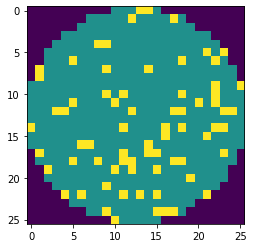

8736:none


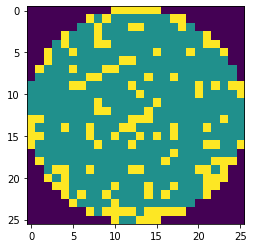

8139:none


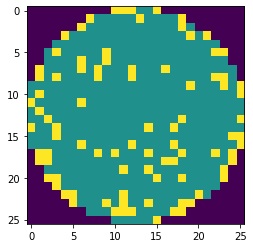

5159:none


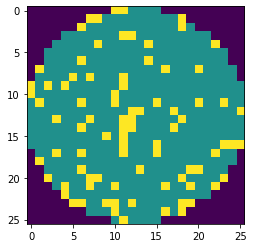

10327:none


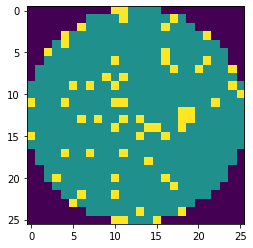

6410:none


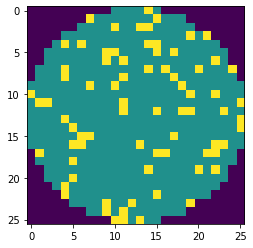

7332:none


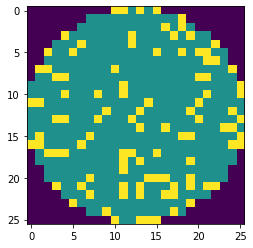

8500:none


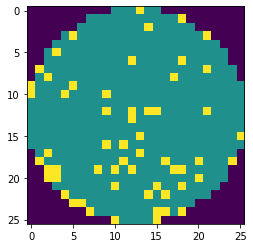

8774:Edge-Loc


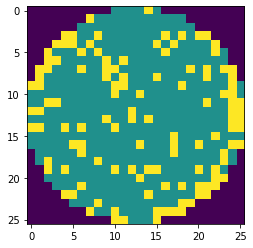

6057:none


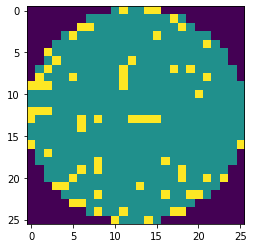

8034:none


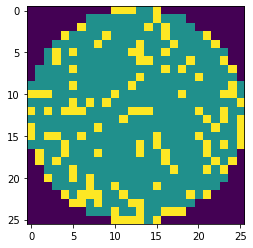

10323:none


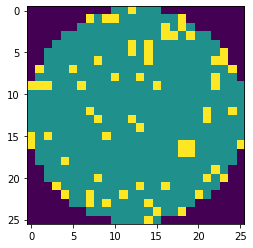

11059:none


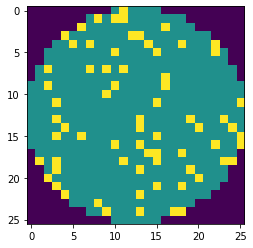

6381:none


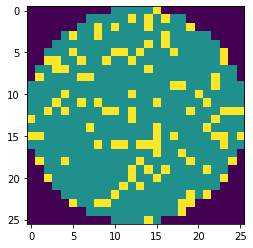

8613:none


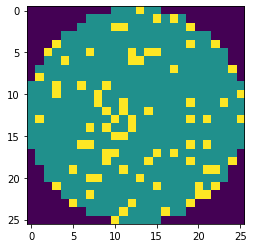

9252:none


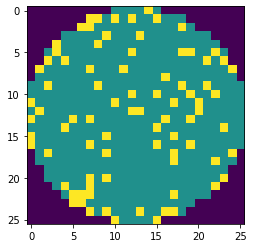

In [14]:
error_label_list = [7876, 8736, 8139, 5159, 10327, 6410, 7332, 8500, 8774, 6057, 8034, 10323, 11059, 6381, 8613, 9252]
for i in error_label_list:
    print(str(i) + ":" + y[i][0])
    plt.imshow(x[i])
    plt.show()

In [15]:
x = x.reshape((-1, 26, 26, 1))
x.shape

(11191, 26, 26, 1)

In [16]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [17]:
faulty_case_dict = dict()

In [18]:
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f])))
    faulty_case_dict[i] = f

Center : 83
Donut : 1
Edge-Loc : 259
Edge-Ring : 15
Loc : 279
Near-full : 9
Random : 60
Scratch : 60
none : 10425


- 14366枚の26x26ウエハの不良パターンは上記のようになっている．

In [19]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [20]:
new_x.shape

(11191, 26, 26, 3)

- new_xを(14366, 26, 26, 3)とし，最後の次元にはウエハの値(0, 1, 2)がそれぞれの値毎にベクトルとしてまとめられている．
- ウエハデータの各ピクセルは，0:ウエハなし，1:正常，2:不良を表す．

### 各ウエハにラベル付け

In [21]:
trials = 2
label_list = []
for i in range(new_x.shape[0]):
    label_dict = {'wafer_id':str(i).zfill(6), 'true_label':y[i][0], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':0, 'inversion':0}, 'trials':trials}
    label_list.append(label_dict)

In [22]:
print(label_list[1])

{'wafer_id': '000001', 'true_label': 'none', 'predict_label': None, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


In [23]:
# check_list = [5160, 9137, 10943, 11345, 9706, 9884, 9029, 9182]
# for j in check_list:
#     plt.imshow(np.argmax(new_x[j], axis=2))
#     print(y[j])
#     plt.show()

### オートエンコーダで学習

#### エンコーダとデコーダのモデルを学習

- モデルの定義をする．

In [24]:
# with tf.device("/cpu:0"):
#     # Encoder
#     input_shape = (26, 26, 3)
#     input_tensor = Input(input_shape)
#     encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

#     latent_vector = layers.MaxPool2D()(encode)

#     # Decoder
#     decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
#     decode_layer_2 = layers.UpSampling2D()
#     output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

#     # connect decoder layers
#     decode = decode_layer_1(latent_vector)
#     decode = decode_layer_2(decode)

#     model = models.Model(input_tensor, output_tensor(decode))

# gpu_count =2
# ae = tf.keras.utils.multi_gpu_model(model, gpus=gpu_count)
# ae.compile(optimizer = 'Adam',
#               loss = 'mse',
#              )

In [25]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], 
#                                         cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()).scope():
with strategy.scope():
    # Encoder
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)
    encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

    latent_vector = layers.MaxPool2D()(encode)

    # Decoder
    decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
    decode_layer_2 = layers.UpSampling2D()
    output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

    # connect decoder layers
    decode = decode_layer_1(latent_vector)
    decode = decode_layer_2(decode)

    ae = models.Model(input_tensor, output_tensor(decode))
    ae.compile(optimizer = 'Adam',
                  loss = 'mse',
                 )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [27]:
ae.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
__________________________________________________

- 層は
    - 入力層
    - 畳み込み層
    - プーリング層
    - 転置畳み込み層
    - アップサンプリング層

In [28]:
epoch=30
batch_size=1024

- 学習を開始する．
- `new_x`を`new_x`にエンコードしデコードする．

In [29]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=1)

Epoch 1/30
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
11/11 [==============================] - 0s 27ms/step - loss: 0.1507
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadc

- エンコーダだけのモデルを定義する．

In [30]:
encoder = models.Model(input_tensor, latent_vector)

- デコーダだけのモデルを定義する．

In [31]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

- `encoder`を使って元のウエハ画像をエンコードする．

In [32]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

- エンコードされた潜伏的な不良ウエハにノイズを負荷する．

In [33]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

- 元のウエハ画像

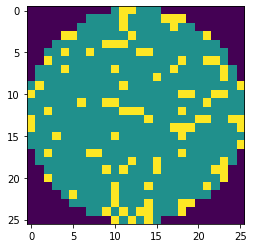

In [34]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

- ノイズが付加されたウエハ画像

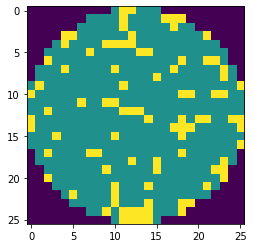

In [35]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

In [36]:
# ノイズが1枚当たりいくつ入るのかを調べる
'''
noised_encoded_x.shape
noise = 0
size = 1000 #new_x.shape[0]
for i in range(size):
    noise += np.count_nonzero(np.argmax(decoder.predict(noised_encoded_x)[i], axis=2) - np.argmax(new_x[i], axis=2))
    print(i)
print(noise)
print(noise / size)
'''

'\nnoised_encoded_x.shape\nnoise = 0\nsize = 1000 #new_x.shape[0]\nfor i in range(size):\n    noise += np.count_nonzero(np.argmax(decoder.predict(noised_encoded_x)[i], axis=2) - np.argmax(new_x[i], axis=2))\n    print(i)\nprint(noise)\nprint(noise / size)\n'

- マスクの定義

In [37]:
# 0がウエハ領域，1が範囲外
mask = new_x[0, :, :, 0].copy()
#out_region = np.where(mask == 1.0)
#in_region = np.where(mask == 0.0)
#mask[out_region] = 0.0
#mask[in_region] = 1.0
#print(mask)

- 90度以外の回転

In [38]:
from PIL import Image, ImageOps
def rotation_pil_mask(img, degree):
    src = Image.fromarray(np.uint8(img))
    img_rotate = np.array(src.rotate(degree))
    
    #before
    '''
    plt.imshow(np.argmax(img_rotate, axis=2))
    plt.title("rotate " + str(degree) + " degree before")
    plt.show()
    '''
    
    #マスクの適用, 
    out_region = np.where((np.argmax(img_rotate, axis=2) != 0) & (mask > 0.0))
    img_rotate[out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(img_rotate, axis=2) == 0) & (mask == 0.0))
    img_rotate[in_region[0], in_region[1]] = np.array([0., 1., 0.])

    #after
    '''plt.imshow(np.argmax(img_rotate, axis=2))
    plt.title("rotate " + str(degree) + " degree after")
    plt.show()'''

    return img_rotate

# 上下方向の鏡映
def flip_pil_mask(img):
    src = Image.fromarray(np.uint8(img))
    img_flip = np.array(ImageOps.flip(src))
    
    #マスクの適用, 
    out_region = np.where((np.argmax(img_flip, axis=2) != 0) & (mask > 0.0))
    img_flip[out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(img_flip, axis=2) == 0) & (mask == 0.0))
    img_flip[in_region[0], in_region[1]] = np.array([0., 1., 0.])
    
    return img_flip

# 左右方向の鏡映
def mirror_pil_mask(img):
    src = Image.fromarray(np.uint8(img))
    img_mirror = np.array(ImageOps.mirror(src))
    
    #マスクの適用, 
    out_region = np.where((np.argmax(img_mirror, axis=2) != 0) & (mask > 0.0))
    img_mirror[out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(img_mirror, axis=2) == 0) & (mask == 0.0))
    img_mirror[in_region[0], in_region[1]] = np.array([0., 1., 0.])
    
    return img_mirror

In [39]:
# 回転の実験
'''
wafer = new_x[np.where(y=="Edge-Loc")[0]].reshape(len(np.where(y=="Edge-Loc")[0]), 26, 26, 3)
plt.imshow(np.argmax(wafer[0], axis=2))
plt.show()


# for i in range(19):
#     rotation_pil_mask(wafer[0], i*20)

plt.imshow(np.argmax(flip_pil_mask(wafer[0]), axis=2))
plt.show()

plt.imshow(np.argmax(mirror_pil_mask(wafer[0]), axis=2))
plt.show()

plt.imshow(np.argmax(flip_pil_mask(mirror_pil_mask(wafer[0])), axis=2))
plt.show()
'''

'\nwafer = new_x[np.where(y=="Edge-Loc")[0]].reshape(len(np.where(y=="Edge-Loc")[0]), 26, 26, 3)\nplt.imshow(np.argmax(wafer[0], axis=2))\nplt.show()\n\n\n# for i in range(19):\n#     rotation_pil_mask(wafer[0], i*20)\n\nplt.imshow(np.argmax(flip_pil_mask(wafer[0]), axis=2))\nplt.show()\n\nplt.imshow(np.argmax(mirror_pil_mask(wafer[0]), axis=2))\nplt.show()\n\nplt.imshow(np.argmax(flip_pil_mask(mirror_pil_mask(wafer[0])), axis=2))\nplt.show()\n'

### データオーギュメンテーション

- データオーギュメンテーションを行う関数を定義する．
- 鏡映，回転を行う

In [40]:
shawon = False
rotation_num = 3
inversion = False
pattern_num = 2000 if shawon else 10000
version = "v5"

In [41]:
# augment function define (add rotate, flip)
def gen_data(wafer, label):
    global label_list
    label_list_pattern = []
    for k, v in enumerate(label_list):
        if v['true_label'] == label:
            label_list_pattern.append(label_list[k])
            
            
    # Encode input wafer
    #encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    aug_x = np.zeros((1, 26, 26, 3))
    
    augmentation_dict = []
    
    ite = rotation_num if label != 'none' else 1
    
    if not shawon:
        for i in range(len(wafer)):
            for j in range(ite):
    #             rotatedata = wafer[i]
                angle = int(180 / ite) if inversion else int(360 / ite)
                rotatedata = rotation_pil_mask(wafer[i], j * angle)
                

                if inversion:
                    flipdata = flip_pil_mask(rotatedata)
                    flipmirrordata = mirror_pil_mask(flipdata)
                    mirrordata = mirror_pil_mask(rotatedata)
                    flipdata = flipdata.reshape(1, 26, 26, 3)
                    flipmirrordata = flipmirrordata.reshape(1, 26, 26, 3)
                    mirrordata = mirrordata.reshape(1, 26, 26, 3)
                    rotatedata = rotatedata.reshape(1, 26, 26, 3)
                    augmentation_dict.append({'wafer_id':str(label_list_pattern[i]['wafer_id']).zfill(6), 'true_label':label_list_pattern[i]['true_label'], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':j*angle, 'inversion':0}, 'trials':trials})
                    aug_x = np.concatenate((aug_x, rotatedata, flipdata, flipmirrordata, mirrordata), axis = 0)
                    augmentation_dict.append({'wafer_id':str(label_list_pattern[i]['wafer_id']).zfill(6), 'true_label':label_list_pattern[i]['true_label'], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':j*angle, 'inversion':1}, 'trials':trials})
                    augmentation_dict.append({'wafer_id':str(label_list_pattern[i]['wafer_id']).zfill(6), 'true_label':label_list_pattern[i]['true_label'], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':j*angle, 'inversion':2}, 'trials':trials})
                    augmentation_dict.append({'wafer_id':str(label_list_pattern[i]['wafer_id']).zfill(6), 'true_label':label_list_pattern[i]['true_label'], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':j*angle, 'inversion':3}, 'trials':trials})
                else:
                    rotatedata = rotatedata.reshape(1, 26, 26, 3)
                    augmentation_dict.append({'wafer_id':str(label_list_pattern[i]['wafer_id']).zfill(6), 'true_label':label_list_pattern[i]['true_label'], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':angle, 'inversion':0}, 'trials':trials})
                    aug_x = np.concatenate((aug_x, rotatedata), axis = 0)

        aug_x = aug_x[1:]
        encoded_x = encoder.predict(aug_x)
    
    else:
        encoded_x = encoder.predict(wafer)
        for i in range(len(wafer)):
            augmentation_dict.append({'wafer_id':str(label_list_pattern[i]['wafer_id']).zfill(6), 'true_label':label_list_pattern[i]['true_label'], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':0, 'inversion':0}, 'trials':trials})
    print(encoded_x.shape)
        
    # Shawon's experiment 2000
    if label != 'none':
        for i in range((pattern_num//len(encoded_x)) + 1):
            noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
            noised_gen_x = decoder.predict(noised_encoded_x)
            gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
            label_list_before = copy.deepcopy(augmentation_dict)
            for j in range(len(encoded_x)):
                label_list_before[j]['augmentation']['noise'] = i+1
            label_list += copy.deepcopy(label_list_before)
    else:
        gen_x = aug_x
        
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

- データオーギュメンテーション（ノイズ付加）したものが適切か調べる

一番左が元画像
右がデータオーギュメンテーション後

In [42]:
# backup
bu_new_x = new_x.copy()
bu_y = y.copy()

In [43]:
# new_x = bu_new_x.copy()
# y = bu_y.copy()
# gen_x = []

- 不良ラベルが付いているデータに対してデータオーギュメンテーションを行う．

In [44]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

(249, 13, 13, 64)
(3, 13, 13, 64)


KeyboardInterrupt: 

In [ ]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))
new_y = y

In [ ]:
if shawon:
    none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=8000, replace=False)]
    new_x = np.delete(new_x, none_idx, axis=0)
    new_y = np.delete(y, none_idx, axis=0)
    for i in sorted(none_idx.tolist(), reverse=True):
        label_list.pop(i)
    print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))
    for f in faulty_case :
        print('{} : {}'.format(f, len(new_y[new_y==f])))

### ノイズ付加後もマスクで直す

In [ ]:
backup_new_x = new_x.copy()
backup_new_y = new_y.copy()

In [ ]:
if not shawon:
    count = 0
    for i in range(len(new_x)):
        error = np.where((np.argmax(new_x[0], axis=2) != np.argmax(new_x[i], axis=2)) & (np.argmax(new_x[0], axis=2) == 0))
        if len(error[0]) > 0:
            #print(str(i) + "error")
            #print(error)
            count += 1
    print(count)

    for i in range(len(new_x)):
        #マスクの適用, 
        out_region = np.where((np.argmax(new_x[i], axis=2) != 0) & (mask > 0.0))
        new_x[i, out_region[0], out_region[1]] = np.array([1., 0., 0.])
        in_region = np.where((np.argmax(new_x[i], axis=2) == 0) & (mask == 0.0))
        new_x[i, in_region[0], in_region[1]] = np.array([0., 1., 0.])

    count = 0
    for i in range(len(new_x)):
        error = np.where((np.argmax(new_x[0], axis=2) != np.argmax(new_x[i], axis=2)) & (np.argmax(new_x[0], axis=2) == 0))
        if len(error[0]) > 0:
            #print(str(i) + "error")
            #print(error)
            count += 1
    print(count)


- データオーギュメンテーションを行った結果，各不良データごとに約40000枚に増えた．
- 合計は368112枚となった．

In [ ]:
x = [0,1,2,3,4,5,6,7,8]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','none']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(20, 20))
    ax = ax.ravel(order='C')
    for j in [k]:
        index = np.where(new_y==labels2[j])[0]
        img = new_x[index]
        #img = new_x[0:10]
        for i in range(10):
            ax[i].imshow(np.argmax(img[i+0], axis=2))
            ax[i].set_title(new_y[index[i+0]], fontsize=15)
            #ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

- 保存/読み込み

In [45]:
MAKE_DATASET = False
ver = 'shawon' if shawon else 'propose'
if MAKE_DATASET:
    pickle_dump(new_x, './data/new_x_' + ver + '.pickle')
    pickle_dump(new_y, './data/new_y_' + ver + '.pickle')
    pickle_dump(label_list, './data/label_list_' + ver + '.pickle')
    
if not MAKE_DATASET:
    new_x = pickle_load('./data/new_x_' + ver + '.pickle')
    new_y = pickle_load('./data/new_y_' + ver + '.pickle')
    label_list = pickle_load('./data/label_list_' + ver + '.pickle')

In [46]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i

In [47]:
for i in range(len(label_list)):
    label_list[i]['true_label'] = new_y[i][0]

In [48]:
# one-hot-encoding
new_y = to_categorical(new_y)

In [49]:
import random
random.seed(1)
def rand_ints_nodup(a, b, k):
    ns = []
    while len(ns) < k:
        n = random.randint(a, b)
        if not n in ns:
            ns.append(n)
    return ns

In [50]:
# testsize = 2000
# randlist = rand_ints_nodup(0, new_x.shape[0]-1, testsize)

# valx = new_x.copy()[randlist, :, :, :]
# valy = y.copy()[randlist, :]

test_size = 705 #705
new_x_size = new_x.shape[0]
testlist = rand_ints_nodup(0, new_x_size-1, test_size)
trainlist = [i for i in range(new_x_size) if i != testlist]
new_X=new_x[trainlist]
new_Y=new_y[trainlist]
test_x=new_x[testlist]
test_y=new_y[testlist]

label_train = copy.deepcopy([label_list[i] for i in trainlist])
label_test = copy.deepcopy([label_list[i] for i in testlist])

test_x.shape

(705, 26, 26, 3)

In [51]:
new_X=new_x
new_Y=new_y

- 学習データとテストデータに分割する．

In [52]:
indices = np.array(range(new_X.shape[0]))

x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(new_X, new_Y, indices,
                                                                test_size=0.33,
                                                                random_state=2020)

In [53]:
label_vali = copy.deepcopy([label_train[i] for i in indices_test.tolist()])
label_train = copy.deepcopy([label_train[i] for i in indices_train.tolist()])

In [54]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (61478, 26, 26, 3), y : (61478, 9)
Test x: (30281, 26, 26, 3), y : (30281, 9)


- 学習データ246635枚，テストデータ121477枚．

- モデルの定義を行う．

### CNN

In [55]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
def create_model():

    with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], 
                                        cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()).scope():
        conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
        conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
        conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

        flat = layers.Flatten()(conv_3)

        dense_1 = layers.Dense(512, activation='relu')(flat)
        dense_2 = layers.Dense(128, activation='relu')(dense_1)
        output_tensor = layers.Dense(9, activation='softmax')(dense_2)

        model = models.Model(input_tensor, output_tensor)
        model.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [56]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=1) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
# results = cross_val_score(model, x_train, y_train, cv=kfold)
# # Check 3-fold model's mean accuracy
# print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

- Cross validiationによる精度は99.55%であった．

- Cross validationなしで学習する．

In [62]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "device:XLA_GPU:0"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:XLA_GPU:0')
Number of devices: 3


In [57]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9259566699880436605,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17463378707137114712
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 855399199316823685
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15202336491714153342
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11718220864
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 5799089570170594671
 physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:05:00.0, compute capability: 6.1",
 name:

In [58]:
model = create_model()
history = model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         epochs=epoch,
         batch_size=batch_size,
         verbose=1           
         )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
61/61 [==============================] - 7s 118ms/step - loss: 0.6375 - accuracy: 0.7771 - val_loss: 0.4752 - val_accuracy: 0.8144
Epoch 2/30
61/61 [==============================] - 5s 88ms/step - loss: 0.1439 - accuracy: 0.9546 - val_loss: 0.8786 - val_accuracy: 0.6979
Epoch 3/30
61/61 [==============================] - 5s 89ms/step - loss: 0.2322 - accuracy: 0.9444 - val_loss: 0.0405 - val_accuracy: 0.9896
Epoch 4/30
61/61 [==============================] - 5s 88ms/step - loss: 0.0215 - accuracy: 0.9952 - val_loss: 0.0169 - val_accuracy: 0.9966
Epoch 5/30
61/61 [==============================] - 5s 89ms/step - loss: 0.0085 - accura

### 結果のラベル付け

In [59]:
y_train_pred = np.argmax(model.predict(x_train),axis=1)
y_train_max = np.argmax(y_train, axis=1)
failure = np.where(y_train_pred != y_train_max)[0]
failure = list(failure)
for i in failure:
    label_train[i]['predict_label'] = y_train_pred[i]
score = model.evaluate(x_train, y_train)[1]
print('Training Accuracy:',score)
trainscore = score

1922/1922 [==============================] - 10s 5ms/step - loss: 1.7229e-05 - accuracy: 1.0000
Training Accuracy: 1.0


- テストデータで評価．    

In [60]:
score = model.evaluate(x_test, y_test)[1]
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)
valiscore = score

947/947 [==============================] - 5s 5ms/step - loss: 0.0155 - accuracy: 0.9974
Testing Accuracy: 0.9974241256713867


In [61]:
y_test_pred = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
failure = np.where(y_test_pred != y_test_max)[0]
failure = list(failure)
print('Number of failure ' + str(len(failure)))

Number of failure 78


faulty case : Edge-Loc
8
predict label : none
{'wafer_id': '002041', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


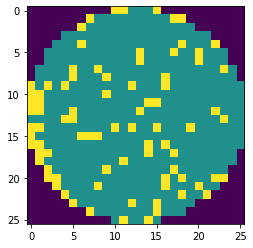

{'wafer_id': '002041', 'true_label': '2', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
2
predict label : Edge-Loc
{'wafer_id': '010862', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


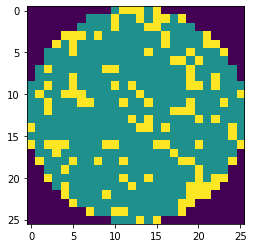

{'wafer_id': '010862', 'true_label': '8', 'predict_label': 2, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '009615', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


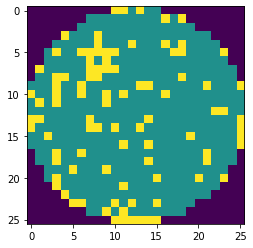

{'wafer_id': '009615', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
2
predict label : Edge-Loc
{'wafer_id': '001518', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


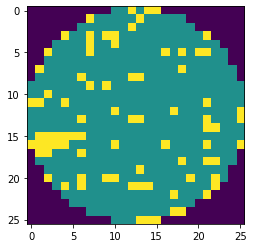

{'wafer_id': '001518', 'true_label': '8', 'predict_label': 2, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '009314', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


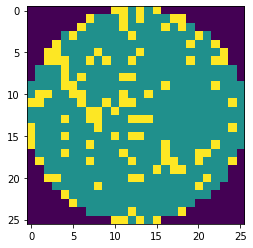

{'wafer_id': '009314', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
4
predict label : Loc
{'wafer_id': '009490', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


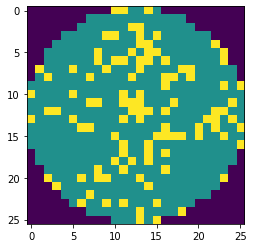

{'wafer_id': '009490', 'true_label': '8', 'predict_label': 4, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '010833', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


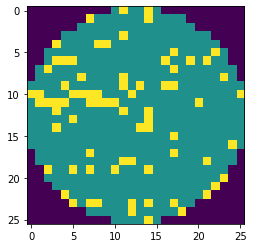

{'wafer_id': '010833', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
3
predict label : Edge-Ring
{'wafer_id': '010112', 'true_label': '8', 'predict_label': 3, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


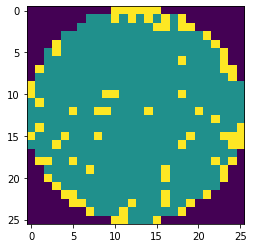

{'wafer_id': '010112', 'true_label': '8', 'predict_label': 3, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '009206', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


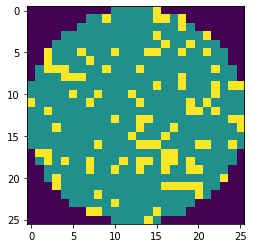

{'wafer_id': '009206', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
7
predict label : Scratch
{'wafer_id': '006077', 'true_label': '8', 'predict_label': 7, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


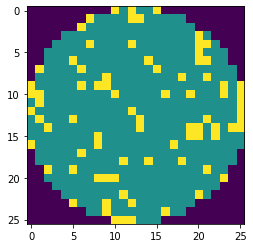

{'wafer_id': '006077', 'true_label': '8', 'predict_label': 7, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '007592', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


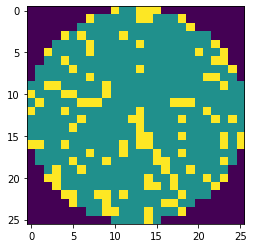

{'wafer_id': '007592', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Edge-Loc
8
predict label : none
{'wafer_id': '006475', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


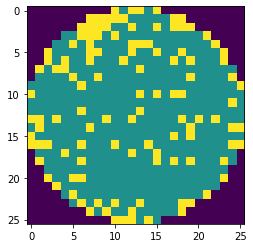

{'wafer_id': '006475', 'true_label': '2', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
2
predict label : Edge-Loc
{'wafer_id': '007723', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


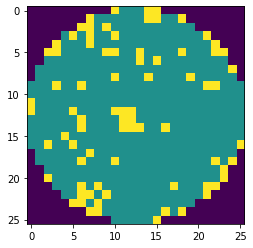

{'wafer_id': '007723', 'true_label': '8', 'predict_label': 2, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Edge-Loc
8
predict label : none
{'wafer_id': '008885', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


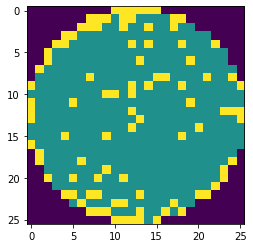

{'wafer_id': '008885', 'true_label': '2', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '006954', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


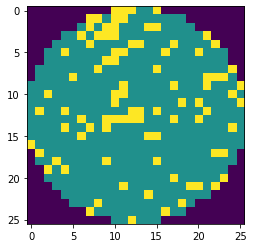

{'wafer_id': '006954', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '005858', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


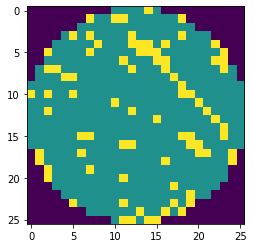

{'wafer_id': '005858', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '008534', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


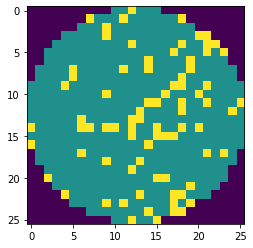

{'wafer_id': '008534', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
4
predict label : Loc
{'wafer_id': '005282', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


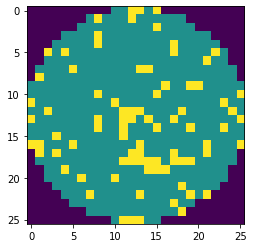

{'wafer_id': '005282', 'true_label': '8', 'predict_label': 4, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
0
predict label : Center
{'wafer_id': '007331', 'true_label': '8', 'predict_label': 0, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


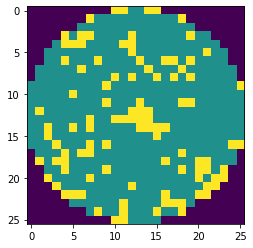

{'wafer_id': '007331', 'true_label': '8', 'predict_label': 0, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '010375', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


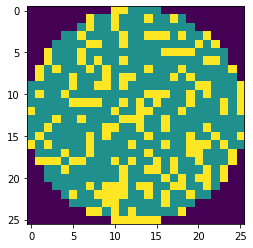

{'wafer_id': '010375', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '008268', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


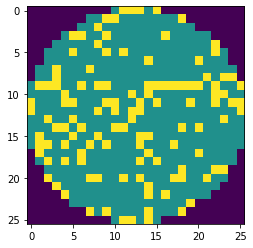

{'wafer_id': '008268', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
4
predict label : Loc
{'wafer_id': '010390', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


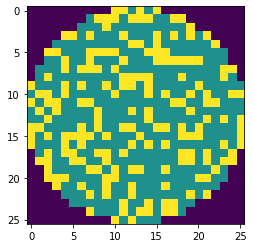

{'wafer_id': '010390', 'true_label': '8', 'predict_label': 4, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Edge-Loc
8
predict label : none
{'wafer_id': '009000', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


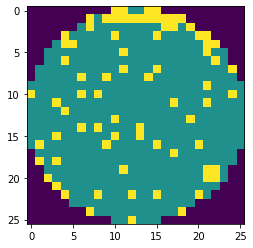

{'wafer_id': '009000', 'true_label': '2', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '009228', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


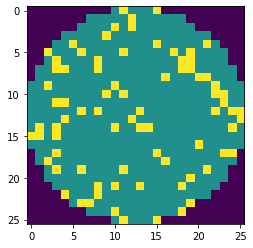

{'wafer_id': '009228', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Edge-Loc
8
predict label : none
{'wafer_id': '008691', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


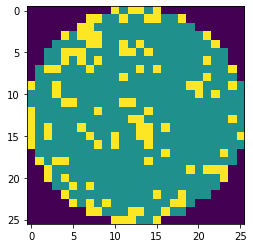

{'wafer_id': '008691', 'true_label': '2', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
2
predict label : Edge-Loc
{'wafer_id': '008401', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


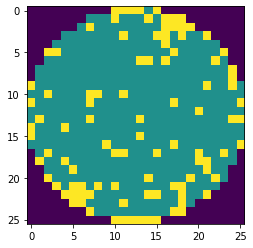

{'wafer_id': '008401', 'true_label': '8', 'predict_label': 2, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
2
predict label : Edge-Loc
{'wafer_id': '009932', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


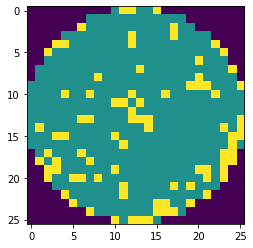

{'wafer_id': '009932', 'true_label': '8', 'predict_label': 2, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Edge-Loc
8
predict label : none
{'wafer_id': '009898', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


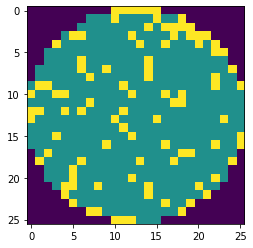

{'wafer_id': '009898', 'true_label': '2', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '003904', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


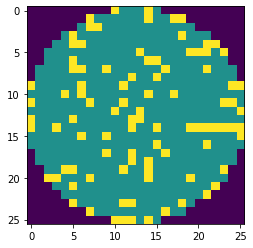

{'wafer_id': '003904', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '006930', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


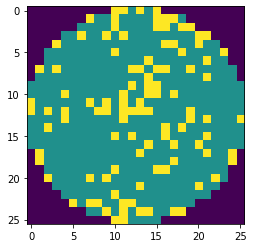

{'wafer_id': '006930', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
4
predict label : Loc
{'wafer_id': '010707', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


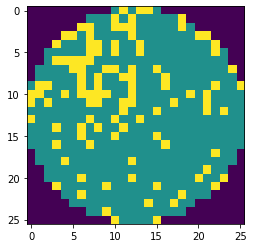

{'wafer_id': '010707', 'true_label': '8', 'predict_label': 4, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
4
predict label : Loc
{'wafer_id': '006894', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


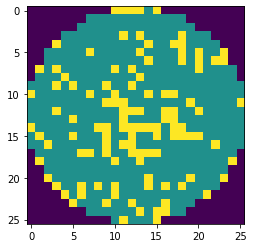

{'wafer_id': '006894', 'true_label': '8', 'predict_label': 4, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '008020', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


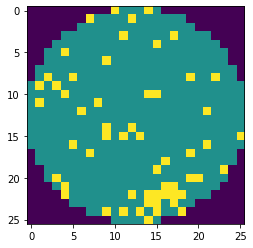

{'wafer_id': '008020', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Edge-Loc
8
predict label : none
{'wafer_id': '007033', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


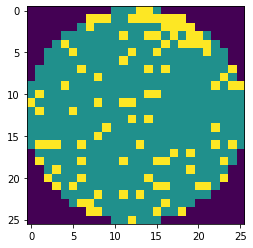

{'wafer_id': '007033', 'true_label': '2', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '007091', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


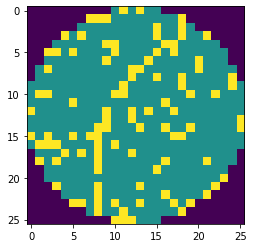

{'wafer_id': '007091', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Edge-Loc
8
predict label : none
{'wafer_id': '008936', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


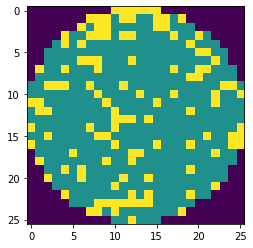

{'wafer_id': '008936', 'true_label': '2', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '009843', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


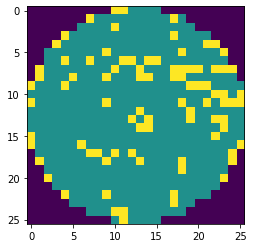

{'wafer_id': '009843', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
4
predict label : Loc
{'wafer_id': '010372', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


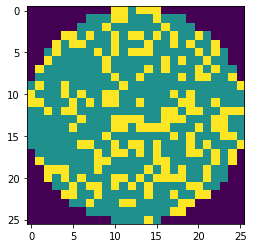

{'wafer_id': '010372', 'true_label': '8', 'predict_label': 4, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
0
predict label : Center
{'wafer_id': '007671', 'true_label': '8', 'predict_label': 0, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


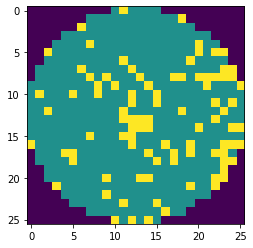

{'wafer_id': '007671', 'true_label': '8', 'predict_label': 0, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '007551', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


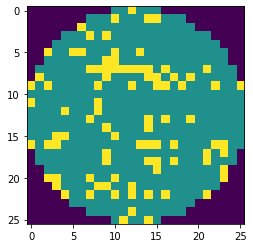

{'wafer_id': '007551', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
0
predict label : Center
{'wafer_id': '008134', 'true_label': '8', 'predict_label': 0, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


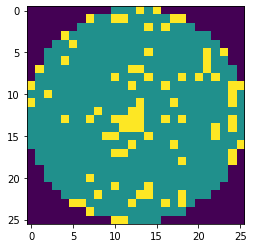

{'wafer_id': '008134', 'true_label': '8', 'predict_label': 0, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '008227', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


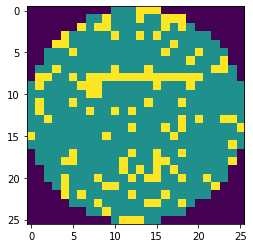

{'wafer_id': '008227', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '008421', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


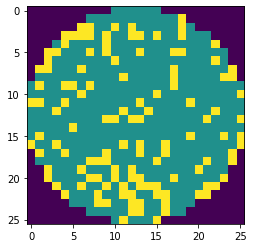

{'wafer_id': '008421', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '008964', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


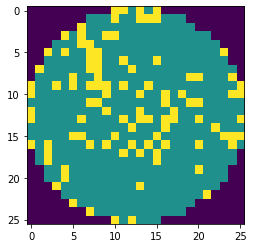

{'wafer_id': '008964', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Edge-Loc
8
predict label : none
{'wafer_id': '008145', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


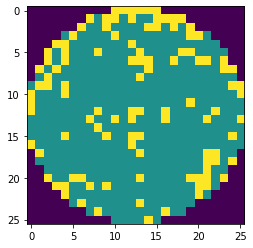

{'wafer_id': '008145', 'true_label': '2', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Edge-Loc
8
predict label : none
{'wafer_id': '008283', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


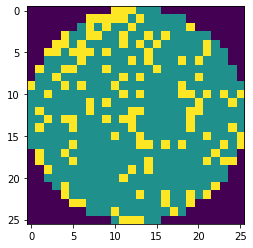

{'wafer_id': '008283', 'true_label': '2', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '007766', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


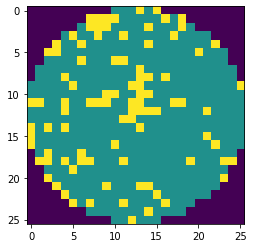

{'wafer_id': '007766', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Edge-Loc
8
predict label : none
{'wafer_id': '005015', 'true_label': '2', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


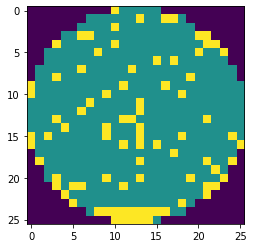

{'wafer_id': '005015', 'true_label': '2', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
2
predict label : Edge-Loc
{'wafer_id': '007037', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


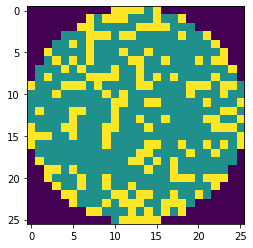

{'wafer_id': '007037', 'true_label': '8', 'predict_label': 2, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '006973', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


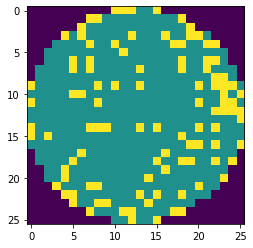

{'wafer_id': '006973', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Center
8
predict label : none
{'wafer_id': '007515', 'true_label': '0', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


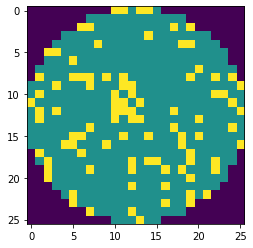

{'wafer_id': '007515', 'true_label': '0', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '002728', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


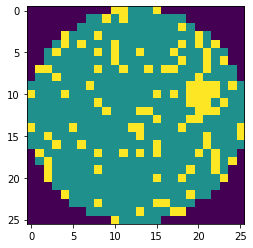

{'wafer_id': '002728', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
2
predict label : Edge-Loc
{'wafer_id': '008417', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


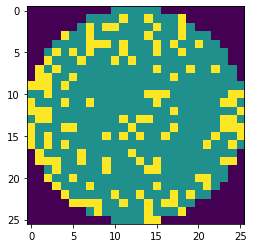

{'wafer_id': '008417', 'true_label': '8', 'predict_label': 2, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '007218', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


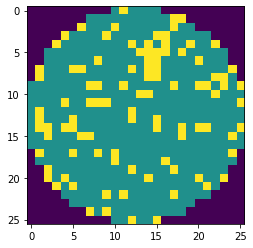

{'wafer_id': '007218', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
4
predict label : Loc
{'wafer_id': '007198', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


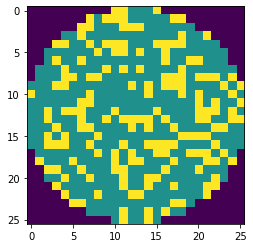

{'wafer_id': '007198', 'true_label': '8', 'predict_label': 4, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
4
predict label : Loc
{'wafer_id': '007667', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


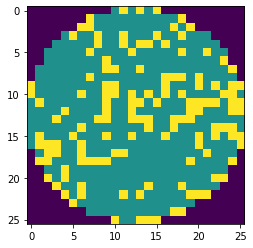

{'wafer_id': '007667', 'true_label': '8', 'predict_label': 4, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '011154', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


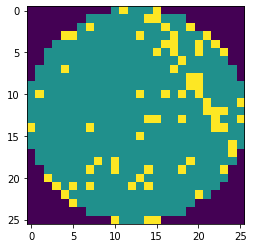

{'wafer_id': '011154', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
4
predict label : Loc
{'wafer_id': '007194', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


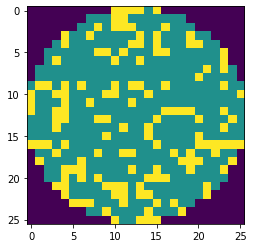

{'wafer_id': '007194', 'true_label': '8', 'predict_label': 4, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
7
predict label : Scratch
{'wafer_id': '004269', 'true_label': '8', 'predict_label': 7, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


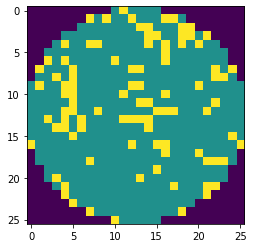

{'wafer_id': '004269', 'true_label': '8', 'predict_label': 7, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Near-full
6
predict label : Random
{'wafer_id': '004629', 'true_label': '5', 'predict_label': 6, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


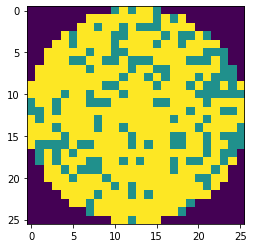

{'wafer_id': '004629', 'true_label': '5', 'predict_label': 6, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '007344', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


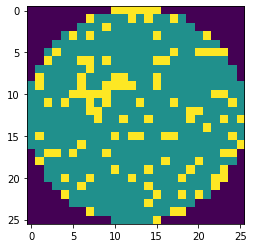

{'wafer_id': '007344', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
2
predict label : Edge-Loc
{'wafer_id': '005323', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


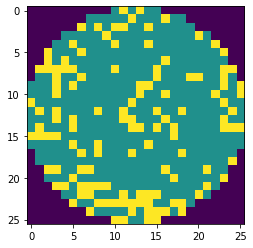

{'wafer_id': '005323', 'true_label': '8', 'predict_label': 2, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Edge-Loc
4
predict label : Loc
{'wafer_id': '007186', 'true_label': '2', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


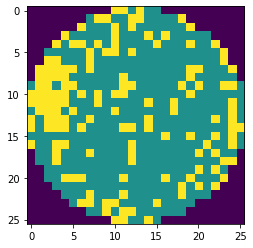

{'wafer_id': '007186', 'true_label': '2', 'predict_label': 4, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '003442', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


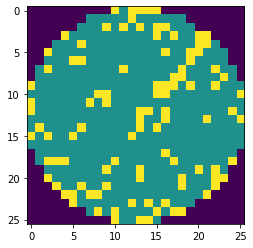

{'wafer_id': '003442', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
2
predict label : Edge-Loc
{'wafer_id': '008651', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


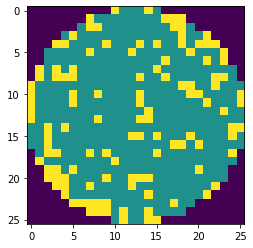

{'wafer_id': '008651', 'true_label': '8', 'predict_label': 2, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
4
predict label : Loc
{'wafer_id': '008777', 'true_label': '8', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


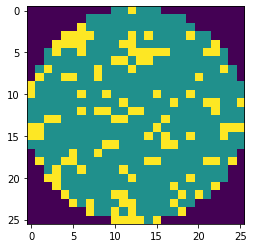

{'wafer_id': '008777', 'true_label': '8', 'predict_label': 4, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Center
8
predict label : none
{'wafer_id': '008963', 'true_label': '0', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


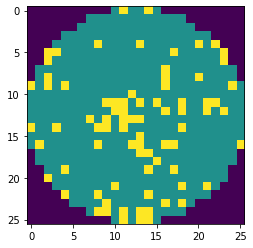

{'wafer_id': '008963', 'true_label': '0', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '009506', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


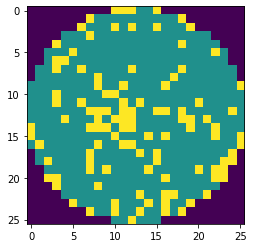

{'wafer_id': '009506', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '007379', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


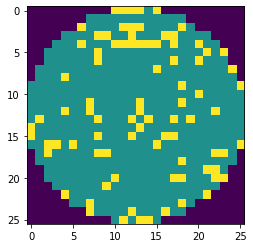

{'wafer_id': '007379', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Center
8
predict label : none
{'wafer_id': '010884', 'true_label': '0', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


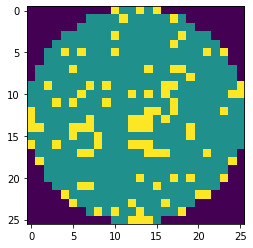

{'wafer_id': '010884', 'true_label': '0', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '007868', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


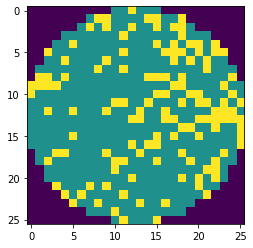

{'wafer_id': '007868', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '007820', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


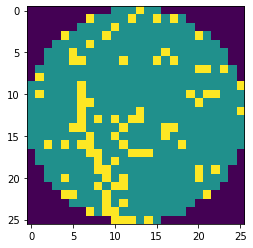

{'wafer_id': '007820', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : none
2
predict label : Edge-Loc
{'wafer_id': '007089', 'true_label': '8', 'predict_label': 2, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


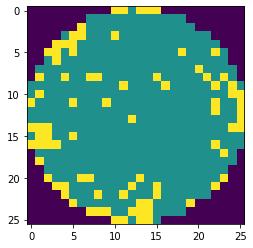

{'wafer_id': '007089', 'true_label': '8', 'predict_label': 2, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '008141', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


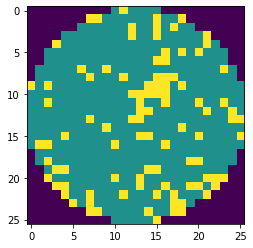

{'wafer_id': '008141', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '007387', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


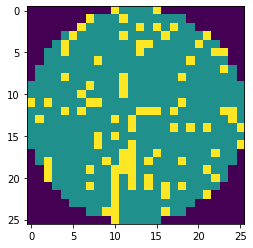

{'wafer_id': '007387', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Random
4
predict label : Loc
{'wafer_id': '008822', 'true_label': '6', 'predict_label': 4, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


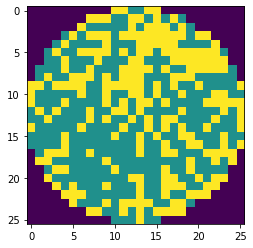

{'wafer_id': '008822', 'true_label': '6', 'predict_label': 4, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Scratch
8
predict label : none
{'wafer_id': '009191', 'true_label': '7', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


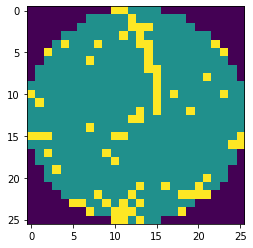

{'wafer_id': '009191', 'true_label': '7', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}
faulty case : Loc
8
predict label : none
{'wafer_id': '007042', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


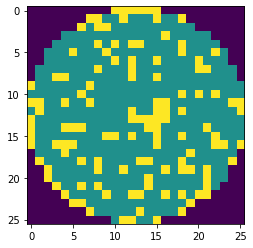

{'wafer_id': '007042', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}


In [62]:
is_exist = os.path.exists(('./img/' + ver + '_' + version + '/imglist.csv'))

with open('./img/' + ver + '_' + version + '/imglist.csv', 'a', newline='') as f:
    fieldnames = ['wafer_id', 'true_label', 'predict_label', 'noise', 'rotation', 'inversion', 'trials', 'type']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not is_exist:
        writer.writeheader()

    for i in failure:
        fig = plt.figure()
        plt.imshow(np.argmax(x_test[i], axis=2))
        print('faulty case : {}'.format(faulty_case_dict[np.argmax(y_test[i])]))
        print(y_test_pred[i])
        print('predict label : {}'.format(faulty_case_dict[y_test_pred[i]]))
        label_vali[i]['predict_label'] = y_test_pred[i]
        print(label_vali[i])
        plt.show()

        img_name = '_'.join(map(str, [label_vali[i]["wafer_id"], label_vali[i]["true_label"], label_vali[i]["predict_label"], label_vali[i]["augmentation"]["noise"], label_vali[i]["augmentation"]["rotation"], label_vali[i]["augmentation"]["inversion"], label_vali[i]["trials"], "validation"]))
        fig.savefig('./img/' + ver + '_' + version + '/' + img_name)
        
        pop_label_vali = label_vali[i].pop('augmentation')
        print(label_vali[i])
        print(pop_label_vali)
        label_vali[i].update(pop_label_vali)
        label_vali[i].update({"type": "validation"})
        writer.writerow(label_vali[i])

- acuurayは99.70%であった．

- 705枚のテストデータで評価

In [63]:
score = model.evaluate(test_x, test_y)[1]
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)
testscore = score

23/23 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.9986
Testing Accuracy: 0.99858158826828


In [64]:
test_y_pred = np.argmax(model.predict(test_x), axis=1)
test_y_max = np.argmax(test_y, axis=1)
failure = np.where(test_y_pred != test_y_max)[0]
failure = list(failure)
print('Number of failure ' + str(len(failure)))

Number of failure 1


faulty case : Loc
predict label : none
{'wafer_id': '002728', 'true_label': '4', 'predict_label': 8, 'augmentation': {'noise': 0, 'rotation': 0, 'inversion': 0}, 'trials': 2}


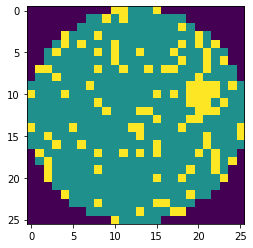

{'wafer_id': '002728', 'true_label': '4', 'predict_label': 8, 'trials': 2}
{'noise': 0, 'rotation': 0, 'inversion': 0}


In [65]:
is_exist = os.path.exists(('./img/' + ver + '_' + version + '/imglist.csv'))

with open('./img/' + ver + '_' + version + '/imglist.csv', 'a', newline='') as f:
    fieldnames = ['wafer_id', 'true_label', 'predict_label', 'noise', 'rotation', 'inversion', 'trials', 'type']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not is_exist:
        writer.writeheader()

    for i in failure:
        fig = plt.figure()
        plt.imshow(np.argmax(test_x[i], axis=2))
        print('faulty case : {}'.format(faulty_case_dict[np.argmax(test_y[i])]))
        print('predict label : {}'.format(faulty_case_dict[test_y_pred[i]]))
        label_test[i]['predict_label'] = test_y_pred[i]
        print(label_test[i])
        plt.show()

        img_name = '_'.join(map(str, [label_test[i]["wafer_id"], label_test[i]["true_label"], label_test[i]["predict_label"], label_test[i]["augmentation"]["noise"], label_test[i]["augmentation"]["rotation"], label_test[i]["augmentation"]["inversion"], label_test[i]["trials"], "test"]))
        fig.savefig('./img/' + ver + '_' + version + '/' + img_name)
        
        pop_label_test = label_test[i].pop('augmentation')
        print(label_test[i])
        print(pop_label_test)
        label_test[i].update(pop_label_test)
        label_test[i].update({"type": "test"})
        writer.writerow(label_test[i])

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [66]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        9280      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               44302848  
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

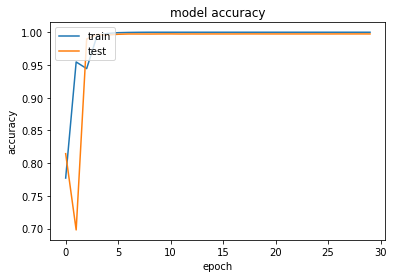

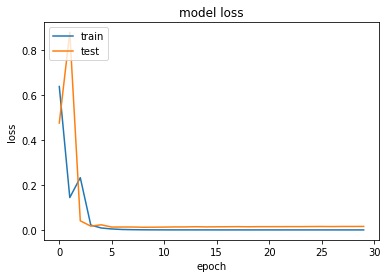

In [67]:
# accuracy plot 
fig1 = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig1.savefig("accuracy.png")

# loss plot
fig2 = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig2.savefig("loss.png")

In [68]:
#y_train_pred = np.argmax(model.predict(x_train))
y_train_pred = np.argmax(model.predict(x_train), axis=1)
y_test_pred = np.argmax(model.predict(x_test), axis=1)
y_train_max = np.argmax(y_train, axis=1)
y_test_max = np.argmax(y_test, axis=1)
test_y_pred = np.argmax(model.predict(test_x), axis=1)
test_y_max = np.argmax(test_y, axis=1)

print(y_train_max[0])
print(y_train_pred[0])

train_acc2 = np.sum(y_train_max == y_train_pred, axis=0, dtype='float') / x_train.shape[0]
test_acc2 = np.sum(y_test_max == y_test_pred, axis=0, dtype='float') / x_test.shape[0]
print('Training acc: {}'.format(train_acc2*100))
print('Testing acc: {}'.format(test_acc2*100))
print("y_train_pred[:100]: ", y_train_pred[:100])
print ("y_train_max[:100]: ", y_train_max[:100])

6
6
Training acc: 100.0
Testing acc: 99.74241273405767
y_train_pred[:100]:  [6 5 5 1 3 7 5 1 1 4 4 6 5 5 7 1 8 7 8 0 0 2 1 0 8 6 5 3 1 2 4 0 2 8 4 1 8
 8 2 1 1 7 1 5 8 2 5 1 1 2 1 5 8 8 4 4 1 4 3 2 3 5 6 1 8 3 7 5 7 6 4 2 1 0
 1 5 1 6 3 4 5 0 2 2 1 7 2 1 7 0 5 4 5 3 7 7 0 8 4 2]
y_train_max[:100]:  [6 5 5 1 3 7 5 1 1 4 4 6 5 5 7 1 8 7 8 0 0 2 1 0 8 6 5 3 1 2 4 0 2 8 4 1 8
 8 2 1 1 7 1 5 8 2 5 1 1 2 1 5 8 8 4 4 1 4 3 2 3 5 6 1 8 3 7 5 7 6 4 2 1 0
 1 5 1 6 3 4 5 0 2 2 1 7 2 1 7 0 5 4 5 3 7 7 0 8 4 2]


### 混同行列

In [69]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- validation confmat

Confusion matrix, without normalization
Normalized confusion matrix


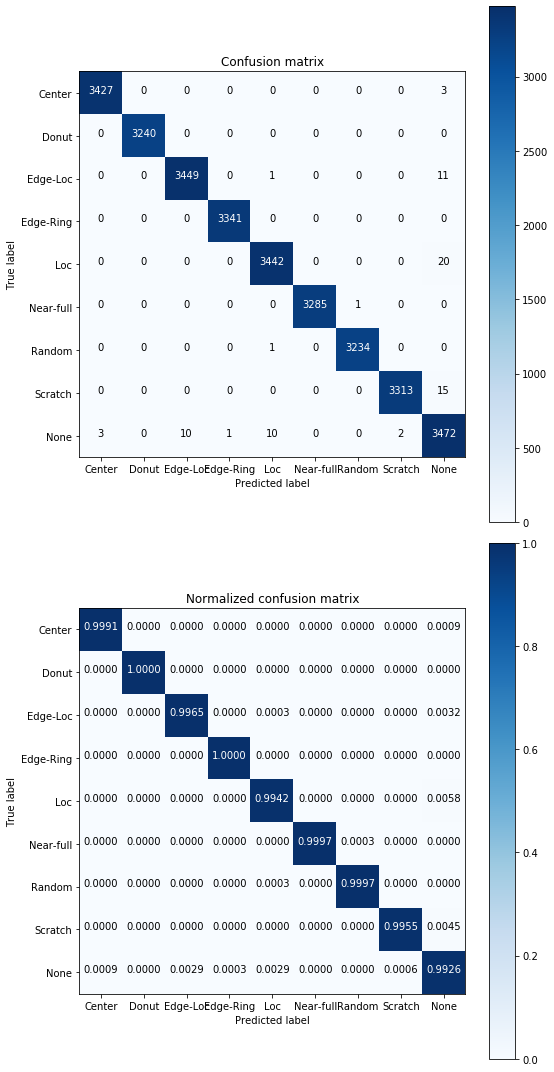

In [70]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_max, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("valiconfmat.png")

- test confmat

Confusion matrix, without normalization
Normalized confusion matrix


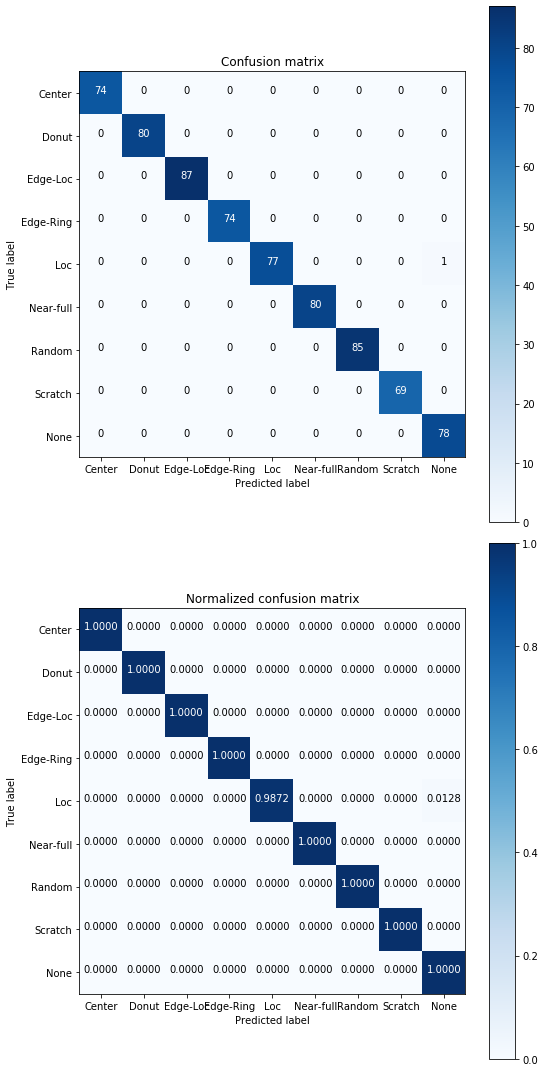

In [71]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_max, test_y_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("testconfmat.png")

In [72]:
import requests

# LINEの設定
path = './lineapi.txt'
with open(path) as f:
    s = f.read()
    line_token = s.rstrip('\n')

# LINEに通知する関数
def line_notify(text):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, data=data, headers=headers, proxies=proxies)

# LINEに画像を送る関数
def line_notify_img(text, imgpath):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text, "notificationDisabled": True}
    files = {"imageFile": open(imgpath, "rb")}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, data=data, files=files, headers=headers, proxies=proxies)
    
line_notify("学習が終了しました")
line_notify("Shawon: " + str(shawon) + ", rotation_num: " + str(rotation_num) + ", inversion: " + str(inversion) + ", trials: " + str(trials))
line_notify_img("正解率", "accuracy.png")
line_notify_img("Loss", "loss.png")
line_notify_img("validation混同行列", "valiconfmat.png")
line_notify_img("test混同行列", "testconfmat.png")
line_notify("train:" + str(trainscore) + "\nvali:" + str(valiscore) + "\ntest:" + str(testscore))